Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     46664
         1.0       1.00      1.00      1.00     46664

    accuracy                           1.00     93328
   macro avg       1.00      1.00      1.00     93328
weighted avg       1.00      1.00      1.00     93328

Confusion Matrix:


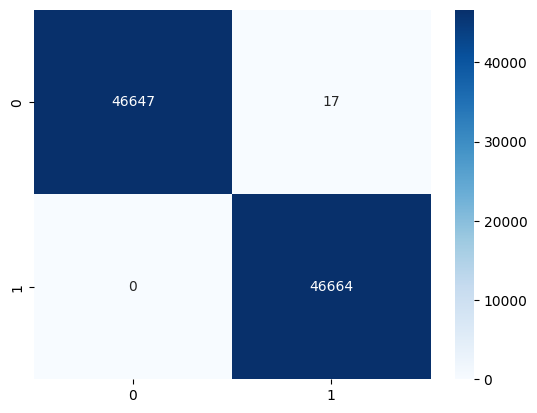

ROC AUC Score: 0.9999991102299475


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
df = pd.read_csv('/content/creditcard.csv')
print(df.columns)  # <-- Check actual column names here

# Use correct fraud label and timestamp column names based on above print
fraud_col = 'Class'  # Replace this with actual fraud label column
time_col = 'Time'    # Replace with actual timestamp column if exists, otherwise remove time features

# Replace deprecated fillna method
df.ffill(inplace=True)

# Add time-based features if timestamp exists
if time_col in df.columns:
    df['hour'] = pd.to_datetime(df[time_col], unit='s').dt.hour
    df['day'] = pd.to_datetime(df[time_col], unit='s').dt.dayofweek
    df.drop(columns=[time_col], inplace=True)

# Feature engineering example: avg spend per user (if user_id exists)
if 'user_id' in df.columns:
    df['avg_user_spend'] = df.groupby('user_id')['amount'].transform('mean')
    df['spend_deviation'] = df['amount'] / df['avg_user_spend']

# Encode categorical columns (if any)
cat_cols = df.select_dtypes(include=['object']).columns
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Separate features and target
X = df.drop(columns=[fraud_col])
y = df[fraud_col]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled)

# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:")
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.show()
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))
